# 1.IMPORT, UPLOAD DAN LOAD MODEL

In [ ]:
# FEATURE VISUALIZATION - WITH FILE UPLOAD
# Upload model.h5 dan lakukan analisis fitur

import pandas as pd
import numpy as np
import cv2 as cv
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import warnings
from google.colab import files

# Suppress warnings
warnings.filterwarnings("ignore")

print("="*60)
print("FEATURE VISUALIZATION - WITH FILE UPLOAD")
print("="*60)

# 1. UPLOAD DAN LOAD MODEL

print("\n=== LANGKAH 1: Upload Model CNN ===")
print("-" * 40)

# Upload model .h5
uploaded = files.upload()

FEATURE VISUALIZATION - WITH FILE UPLOAD

=== LANGKAH 1: Upload Model CNN ===
----------------------------------------


Saving facial_expression_model.h5 to facial_expression_model.h5


In [ ]:
# Memuat model yang diunggah
model_path = list(uploaded.keys())[0]
print(f"\nLoading model from uploaded file: {model_path}")

try:
    original_model = load_model(model_path)
    print(f"✓ Model berhasil dimuat: {model_path}")
    print(f"Model type: {type(original_model)}")
    print(f"Model input shape: {original_model.input_shape}")
    print(f"Model output shape: {original_model.output_shape}")

    # ADVANCED FIX: Force build model dengan berbagai cara
    print("Forcing model build...")

    # Detect input shape
    input_shape = original_model.input_shape
    if isinstance(input_shape, list):
        input_shape = input_shape[0]

    # Create sample input
    sample_input = np.random.random((1,) + input_shape[1:])

    # Method 1: Call model prediction untuk build semua layer
    try:
        _ = original_model.predict(sample_input, verbose=0)
        print("✓ Model built via predict()")
    except:
        pass

    # Method 2: Call model langsung
    try:
        _ = original_model(sample_input)
        print("✓ Model built via direct call")
    except:
        pass

    # Method 3: Build model secara eksplisit
    try:
        original_model.build(input_shape)
        print("✓ Model built via build()")
    except:
        pass

    print(f"Model built status: {original_model.built}")

except Exception as e:
    print(f"✗ Error loading model: {e}")
    exit()


Loading model from uploaded file: facial_expression_model.h5


✓ Model berhasil dimuat: facial_expression_model.h5
Model type: <class 'keras.src.models.sequential.Sequential'>
Model input shape: (None, 48, 48, 1)
Model output shape: (None, 7)
Forcing model build...


✓ Model built via predict()
✓ Model built via direct call
✓ Model built via build()
Model built status: True


# 2.ADVANCED MODEL ANALYSIS & RECONSTRUCTION

In [ ]:

# 2. ADVANCED MODEL ANALYSIS & RECONSTRUCTION

print("\n=== LANGKAH 2: Advanced Model Analysis ===")
print("-" * 40)

def get_all_layers(model, layer_list=None):
    """Recursively get all layers from nested model"""
    if layer_list is None:
        layer_list = []

    for layer in model.layers:
        layer_list.append(layer)
        # Check if layer is a nested model
        if hasattr(layer, 'layers') and len(layer.layers) > 0:
            get_all_layers(layer, layer_list)

    return layer_list

# Get all layers recursively
all_layers = get_all_layers(original_model)
print(f"Total layers found: {len(all_layers)}")

# Find convolutional layers
conv_layers = []
conv_layer_indices = []

for i, layer in enumerate(all_layers):
    print(f"Layer {i}: {layer.name} - {type(layer).__name__}")
    if isinstance(layer, tf.keras.layers.Conv2D) or 'conv2d' in layer.name.lower():
        conv_layers.append(layer)
        conv_layer_indices.append(i)
        print(f"  → Convolutional layer found!")

print(f"\nConvolutional layers: {len(conv_layers)}")
for i, layer in enumerate(conv_layers):
    print(f"  {i}: {layer.name} - Filters: {layer.filters if hasattr(layer, 'filters') else 'Unknown'}")


=== LANGKAH 2: Advanced Model Analysis ===
----------------------------------------
Total layers found: 23
Layer 0: conv2d_1 - Conv2D
  → Convolutional layer found!
Layer 1: batchnorm_1 - BatchNormalization
Layer 2: conv2d_2 - Conv2D
  → Convolutional layer found!
Layer 3: batchnorm_2 - BatchNormalization
Layer 4: maxpool2d_1 - MaxPooling2D
Layer 5: dropout_1 - Dropout
Layer 6: conv2d_3 - Conv2D
  → Convolutional layer found!
Layer 7: batchnorm_3 - BatchNormalization
Layer 8: conv2d_4 - Conv2D
  → Convolutional layer found!
Layer 9: batchnorm_4 - BatchNormalization
Layer 10: maxpool2d_2 - MaxPooling2D
Layer 11: dropout_2 - Dropout
Layer 12: conv2d_5 - Conv2D
  → Convolutional layer found!
Layer 13: batchnorm_5 - BatchNormalization
Layer 14: conv2d_6 - Conv2D
  → Convolutional layer found!
Layer 15: batchnorm_6 - BatchNormalization
Layer 16: maxpool2d_3 - MaxPooling2D
Layer 17: dropout_3 - Dropout
Layer 18: flatten - Flatten
Layer 19: dense_1 - Dense
Layer 20: batchnorm_7 - BatchNormal

# 3.FEATURE EXTRACTION

In [ ]:
# 3. ALTERNATIVE FEATURE EXTRACTION APPROACH (FIXED)

def extract_features_alternative(model, layer_index, input_data):
    """
    Alternative approach untuk extract features menggunakan layer indexing
    """
    try:
        # Create intermediate model up to specified layer
        all_layers = get_all_layers(model)
        target_layer = all_layers[layer_index]

        # Method 1: Try to create submodel - FIXED IMPORT
        try:
            # ✓ FIXED: Use tf.keras.Model explicitly
            temp_model = tf.keras.Model(inputs=model.input, outputs=target_layer.output)
            features = temp_model.predict(input_data, verbose=0)
            return features, target_layer.name
        except Exception as e1:
            print(f"Method 1 failed: {e1}")

        # Method 2: Manual forward pass
        try:
            x = input_data
            for i, layer in enumerate(all_layers[:layer_index + 1]):
                if hasattr(layer, '__call__'):
                    x = layer(x)
                if i == layer_index:
                    return x.numpy(), layer.name
        except Exception as e2:
            print(f"Method 2 failed: {e2}")

        # Method 3: Layer by layer prediction - ENHANCED
        try:
            # Create a functional model approach
            x = model.input
            for i, layer in enumerate(all_layers[:layer_index + 1]):
                try:
                    x = layer(x)
                    if i == layer_index:
                        # Create intermediate model
                        intermediate_model = tf.keras.Model(inputs=model.input, outputs=x)
                        features = intermediate_model.predict(input_data, verbose=0)
                        return features, target_layer.name
                except:
                    continue
        except Exception as e3:
            print(f"Method 3 failed: {e3}")

        # Method 4: NEW - Direct layer output extraction
        try:
            # Get layer output using functional API
            layer_input = model.input
            layer_outputs = []

            # Build path to target layer
            x = layer_input
            for i, layer in enumerate(all_layers):
                x = layer(x)
                layer_outputs.append(x)
                if i == layer_index:
                    break

            # Create model for this specific output
            feature_model = tf.keras.Model(inputs=layer_input, outputs=layer_outputs[layer_index])
            features = feature_model.predict(input_data, verbose=0)
            return features, target_layer.name

        except Exception as e4:
            print(f"Method 4 failed: {e4}")

        return None, target_layer.name

    except Exception as e:
        print(f"All methods failed for layer {layer_index}: {e}")
        return None, f"layer_{layer_index}"

def visualize_features_alternative(features, layer_name, num_filters=16):
    """
    Visualize features menggunakan output dari extract_features_alternative
    """
    if features is None:
        print(f"⚠ No features to visualize for {layer_name}")
        return

    try:
        # Ambil jumlah filter yang tersedia
        if len(features.shape) == 4:  # (batch, height, width, channels)
            actual_filters = min(num_filters, features.shape[-1])
        else:
            print(f"⚠ Unexpected feature shape: {features.shape}")
            return

        square = int(np.sqrt(actual_filters))
        if square * square < actual_filters:
            square += 1

        # Plot feature maps
        fig, axes = plt.subplots(square, square, figsize=(12, 12))
        fig.suptitle(f'Feature Maps dari {layer_name} (Shape: {features.shape})', fontsize=16)

        # Handle different subplot configurations
        if square == 1:
            axes = [axes]
        elif square > 1:
            axes = axes.flatten()

        for i in range(square * square):
            if i < actual_filters:
                axes[i].imshow(features[0, :, :, i], cmap='viridis')
                axes[i].set_title(f'Filter {i + 1}')
                axes[i].axis('off')
            else:
                axes[i].axis('off')

        plt.tight_layout()
        plt.show()

        print(f"✓ Feature maps visualized for {layer_name}: {features.shape}")

    except Exception as e:
        print(f"⚠ Error in visualize_features_alternative: {e}")

def visualize_conv_filters(conv_layer, layer_name):
    """
    Visualize convolutional filters
    """
    try:
        weights = conv_layer.get_weights()
        if len(weights) == 0:
            print(f"⚠ No weights found for {layer_name}")
            return

        filters = weights[0]  # Get filter weights
        print(f"Filter shape for {layer_name}: {filters.shape}")

        # Normalize filters
        f_min, f_max = filters.min(), filters.max()
        if f_max > f_min:
            filters_norm = (filters - f_min) / (f_max - f_min)
        else:
            filters_norm = filters

        # Determine number of filters to show
        n_filters = min(16, filters_norm.shape[-1])
        square = int(np.sqrt(n_filters))
        if square * square < n_filters:
            square += 1

        # Plot filters
        fig, axes = plt.subplots(square, square, figsize=(10, 10))
        fig.suptitle(f'Learned Filters - {layer_name}', fontsize=16)

        if square == 1:
            axes = [axes]
        elif square > 1:
            axes = axes.flatten()

        for i in range(square * square):
            if i < n_filters:
                # Handle different filter dimensions
                if len(filters_norm.shape) == 4:  # (height, width, in_channels, out_channels)
                    if filters_norm.shape[2] == 1:  # Grayscale input
                        filter_img = filters_norm[:, :, 0, i]
                    else:  # Multi-channel input
                        filter_img = np.mean(filters_norm[:, :, :, i], axis=2)
                else:
                    filter_img = filters_norm[:, :, i] if len(filters_norm.shape) == 3 else filters_norm

                axes[i].imshow(filter_img, cmap='gray')
                axes[i].set_title(f'Filter {i + 1}')
                axes[i].axis('off')
            else:
                axes[i].axis('off')

        plt.tight_layout()
        plt.show()
        print(f"✓ Filters visualized for {layer_name}")

    except Exception as e:
        print(f"⚠ Error visualizing filters for {layer_name}: {e}")

Penjelasn:

**Fungsi extract_features_alternative**

Fungsi ini bertujuan untuk mengambil (extract) fitur dari sebuah layer tertentu pada model CNN untuk sebuah input data gambar, dengan pendekatan alternatif yang mencoba beberapa cara agar proses ekstraksi ini berhasil meskipun struktur model atau lapisan tertentu rumit.

Cara kerja:
1. Ambil semua layer model secara berurutan menggunakan fungsi get_all_layers(model).
2. Tentukan layer target yang ingin diambil fitur outputnya berdasarkan indeks (layer_index).
3. Coba beberapa metode berbeda untuk membuat model sementara yang outputnya adalah output dari layer target:
  - Method 1: Buat sub-model baru dari input asli ke output layer target, lalu jalankan prediksi untuk input.
  - Method 2: Jalankan manual forward pass dari input melewati layer-layer sampai layer target.
  - Method 3: Sama seperti Method 1, tapi dengan cara yang sedikit berbeda untuk memastikan model dibuat dan diprediksi dengan benar.
  - Method 4: Buat daftar output untuk setiap layer sampai layer target, lalu buat model untuk output layer target dan jalankan prediksi.
4. Jika semua metode gagal, kembalikan None dan nama layer sebagai tanda tidak ada fitur yang berhasil diekstraksi.

**Fungsi visualize_features_alternative**
Fungsi ini digunakan untuk menampilkan (visualisasi) fitur yang sudah diekstraksi dari layer tertentu dalam bentuk feature maps.

Cara kerja:
1. Cek apakah fitur yang diberikan ada, jika tidak ada, tampilkan peringatan.
2. Pastikan fitur berbentuk 4 dimensi (batch_size, height, width, channels) sesuai output CNN.
3. Tentukan berapa banyak filter (channels) yang akan divisualisasikan, maksimal 16.
4. Buat grid plot persegi yang cukup untuk menampilkan semua fitur.
5. Tampilkan setiap filter (feature map) dalam bentuk gambar dengan skala warna viridis.
5. Matikan axis dan beri judul setiap subplot sesuai nomor filter.
7. Tampilkan seluruh grid fitur.

**Fungsi visualize_conv_filters**
Fungsi ini bertujuan untuk menampilkan visualisasi bobot (weight) filter yang dipelajari oleh layer convolutional tertentu.

Cara kerja:
1. Ambil bobot (weights) filter dari layer konvolusi. Bobot ini adalah matriks yang digunakan untuk mendeteksi pola pada gambar.
2. Normalisasi bobot filter agar nilainya berada di rentang [0, 1] agar dapat divisualisasikan.
3. Tentukan maksimal 16 filter yang akan ditampilkan.
4. Buat grid plot persegi untuk memvisualisasikan filter.
5. Untuk tiap filter, tampilkan bobotnya sebagai gambar grayscale.
  - Jika filter memiliki banyak channel (misalnya input RGB), ambil rata-rata nilai antar channel.
6. Matikan axis dan beri judul filter.
7. Tampilkan seluruh filter dalam satu grid.

In [ ]:
# # 4. GRAD-CAM ALTERNATIVE IMPLEMENTATION (FIXED)

# def gradcam_alternative(model, img_array, conv_layer_index, class_names):
#     """
#     Alternative Grad-CAM implementation - FIXED
#     """
#     try:
#         all_layers = get_all_layers(model)
#         target_conv_layer = all_layers[conv_layer_index]

#         # Get model prediction
#         preds = model.predict(img_array, verbose=0)
#         pred_class = np.argmax(preds[0])
#         pred_prob = np.max(preds[0])

#         print(f"Prediction: {class_names[pred_class]} ({pred_prob:.3f})")

#         # Try to create grad model - FIXED IMPORT
#         try:
#             # ✓ FIXED: Use tf.keras.Model explicitly
#             grad_model = tf.keras.Model(
#                 inputs=model.input,
#                 outputs=[target_conv_layer.output, model.output]
#             )

#             with tf.GradientTape() as tape:
#                 conv_outputs, predictions = grad_model(img_array)
#                 class_channel = predictions[:, pred_class]

#             grads = tape.gradient(class_channel, conv_outputs)
#             pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#             conv_outputs = conv_outputs[0]
#             heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
#             heatmap = tf.squeeze(heatmap)
#             heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

#             return heatmap.numpy(), pred_class, pred_prob

#         except Exception as e:
#             print(f"Grad-CAM method 1 failed: {e}")

#             # Alternative Grad-CAM approach
#             try:
#                 # Create separate models for conv output and final prediction
#                 conv_model = tf.keras.Model(inputs=model.input, outputs=target_conv_layer.output)

#                 with tf.GradientTape() as tape:
#                     # Get conv layer output
#                     conv_output = conv_model(img_array)
#                     # Get prediction from full model
#                     prediction = model(img_array)
#                     # Get the predicted class score
#                     class_channel = prediction[:, pred_class]

#                 # Calculate gradients
#                 grads = tape.gradient(class_channel, conv_output)

#                 if grads is not None:
#                     # Global average pooling of gradients
#                     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#                     # Weight the conv output by the gradients
#                     conv_output = conv_output[0]
#                     heatmap = conv_output @ pooled_grads[..., tf.newaxis]
#                     heatmap = tf.squeeze(heatmap)

#                     # Normalize heatmap
#                     heatmap = tf.maximum(heatmap, 0)
#                     if tf.math.reduce_max(heatmap) > 0:
#                         heatmap = heatmap / tf.math.reduce_max(heatmap)

#                     return heatmap.numpy(), pred_class, pred_prob
#                 else:
#                     print("Gradients are None")
#                     return None, pred_class, pred_prob

#             except Exception as e2:
#                 print(f"Grad-CAM method 2 failed: {e2}")
#                 return None, pred_class, pred_prob

#     except Exception as e:
#         print(f"Grad-CAM alternative failed: {e}")
#         return None, None, None

In [ ]:
# 5. CLASS NAMES

class_names = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']



=== LANGKAH 3: Filter Visualization ===
----------------------------------------

Analyzing filters from layer 1: conv2d_1
Filter shape for conv2d_1: (5, 5, 1, 512)


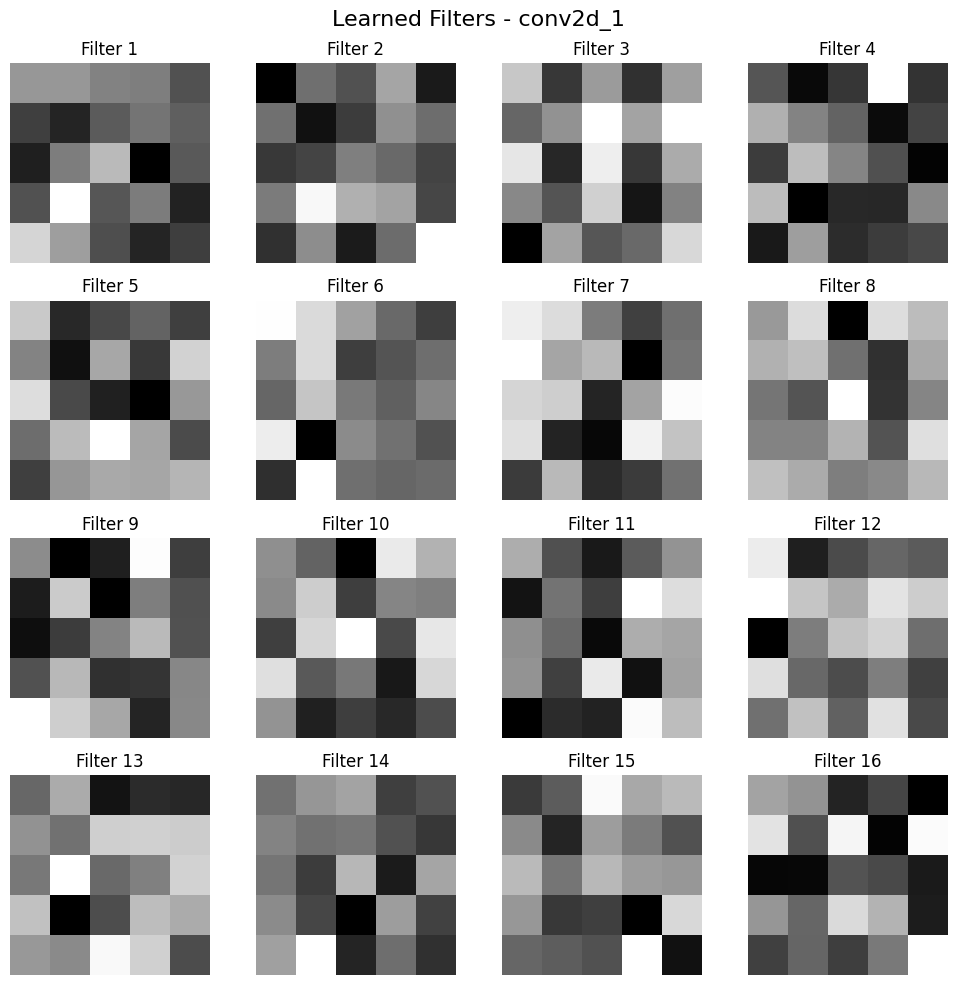

✓ Filters visualized for conv2d_1

Analyzing filters from layer 2: conv2d_2
Filter shape for conv2d_2: (5, 5, 512, 256)


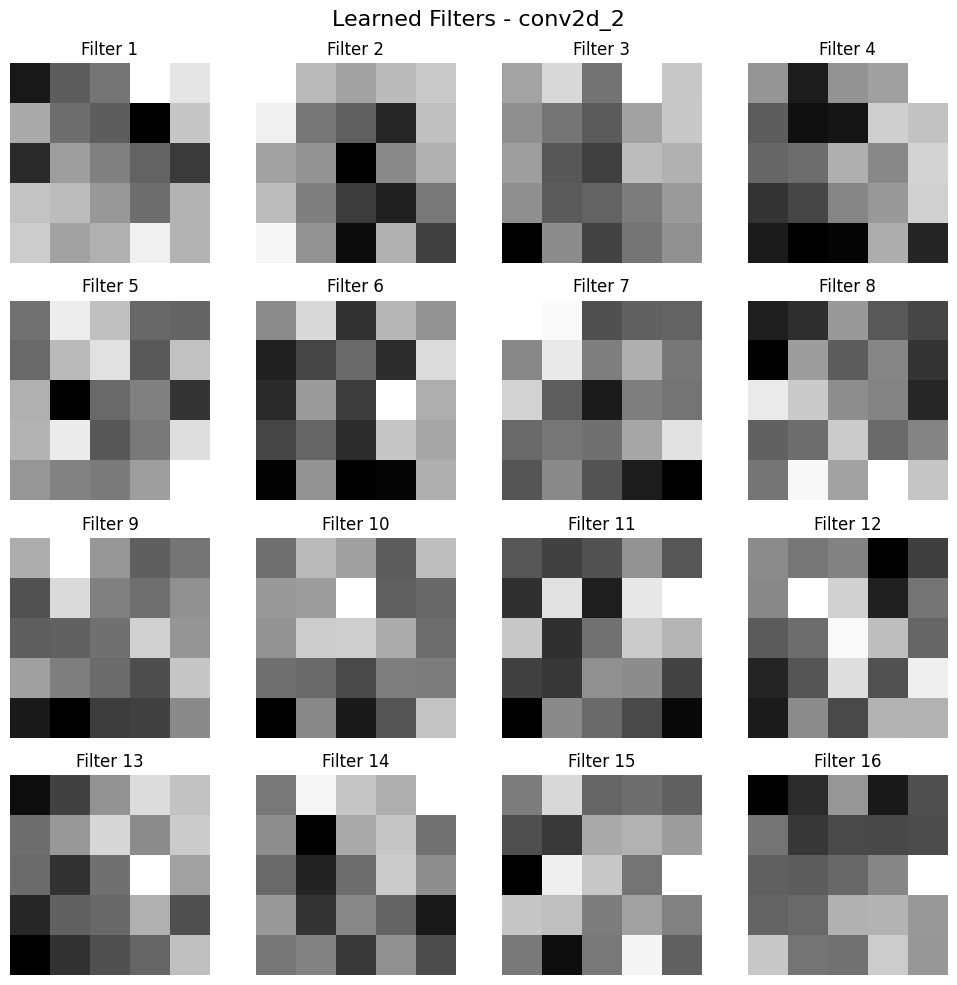

✓ Filters visualized for conv2d_2

Analyzing filters from layer 3: conv2d_3
Filter shape for conv2d_3: (3, 3, 256, 128)


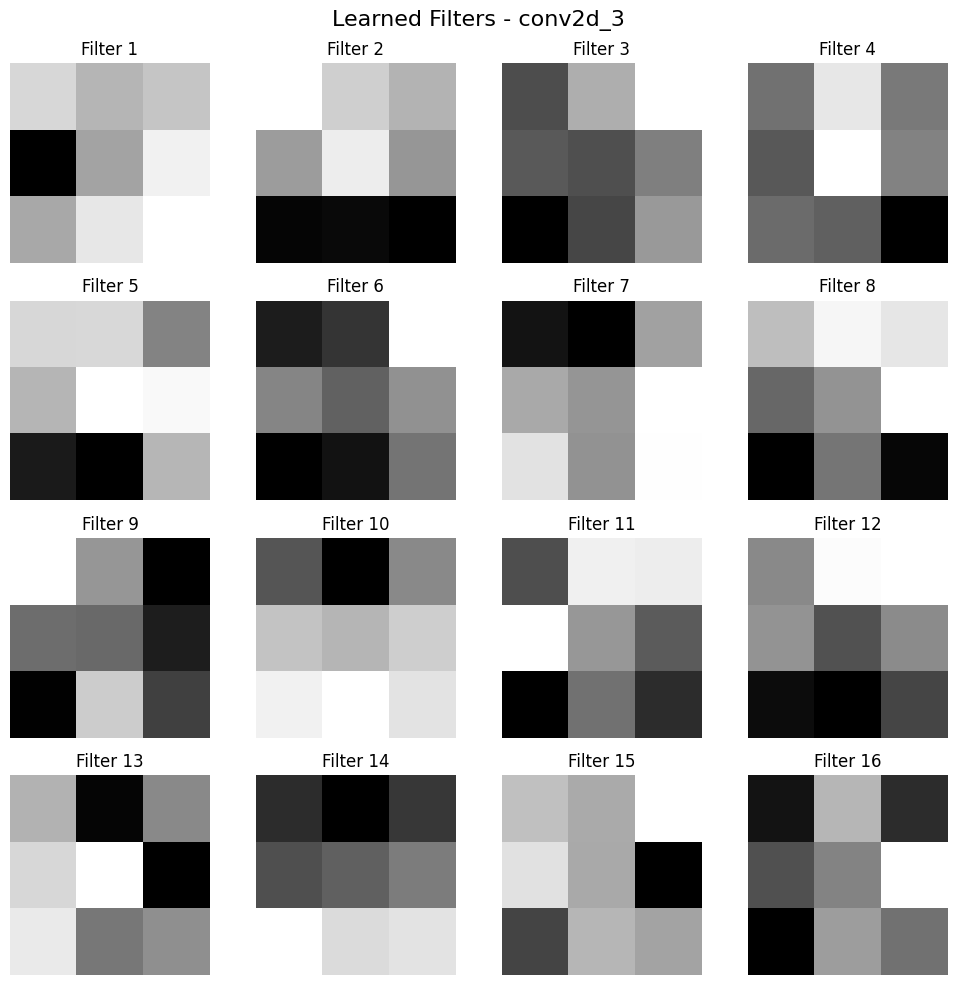

✓ Filters visualized for conv2d_3

Analyzing filters from layer 4: conv2d_4
Filter shape for conv2d_4: (3, 3, 128, 128)


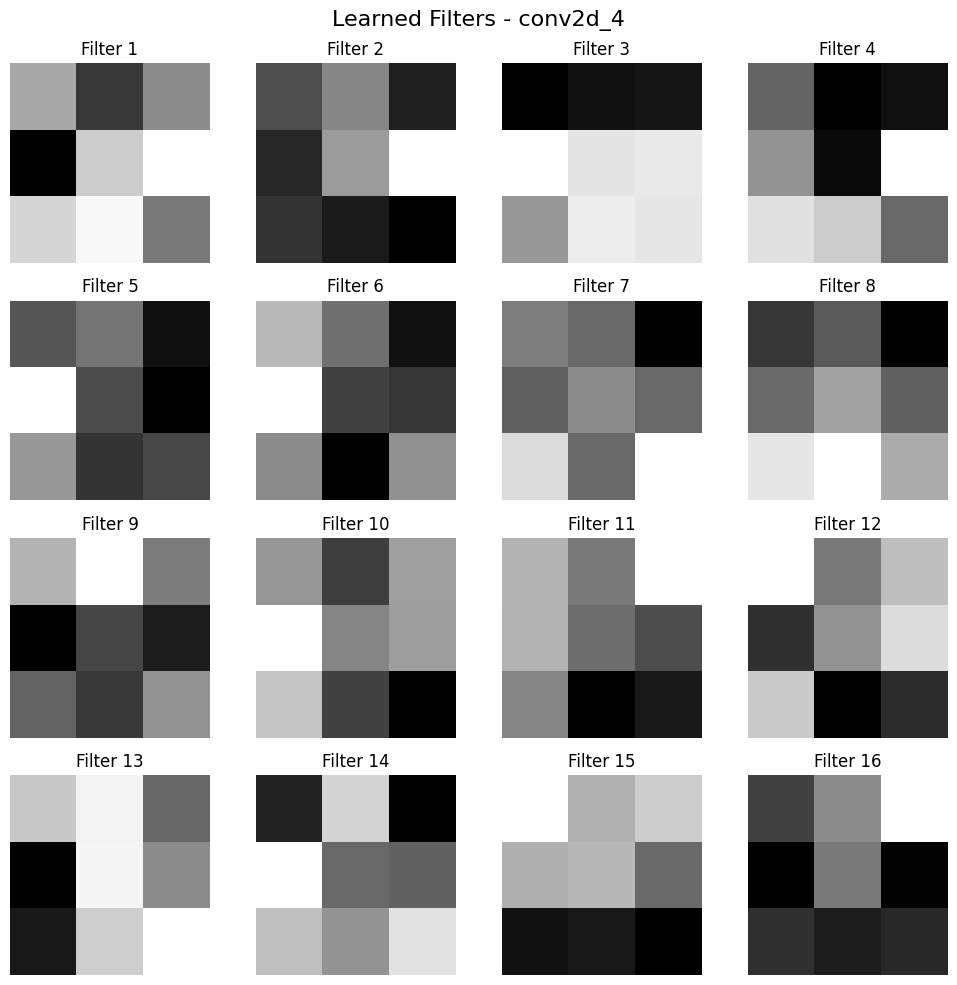

✓ Filters visualized for conv2d_4

Analyzing filters from layer 5: conv2d_5
Filter shape for conv2d_5: (3, 3, 128, 256)


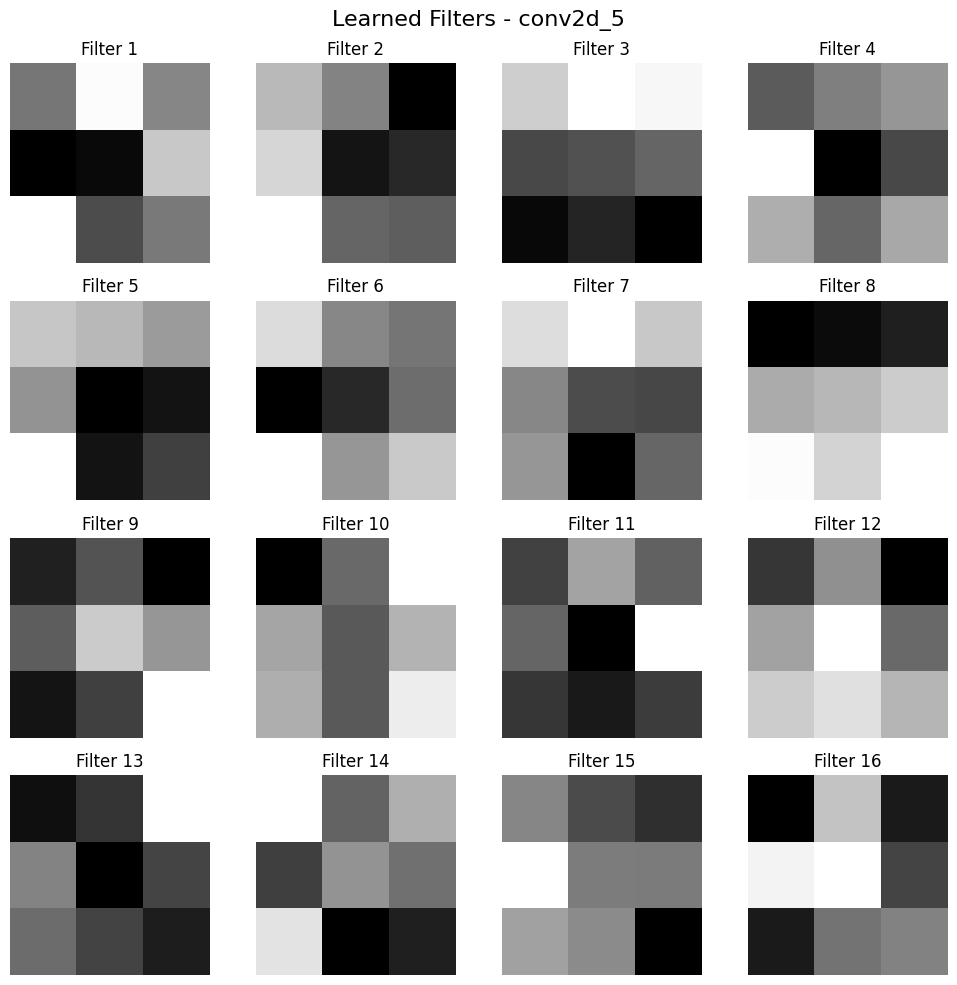

✓ Filters visualized for conv2d_5

Analyzing filters from layer 6: conv2d_6
Filter shape for conv2d_6: (3, 3, 256, 512)


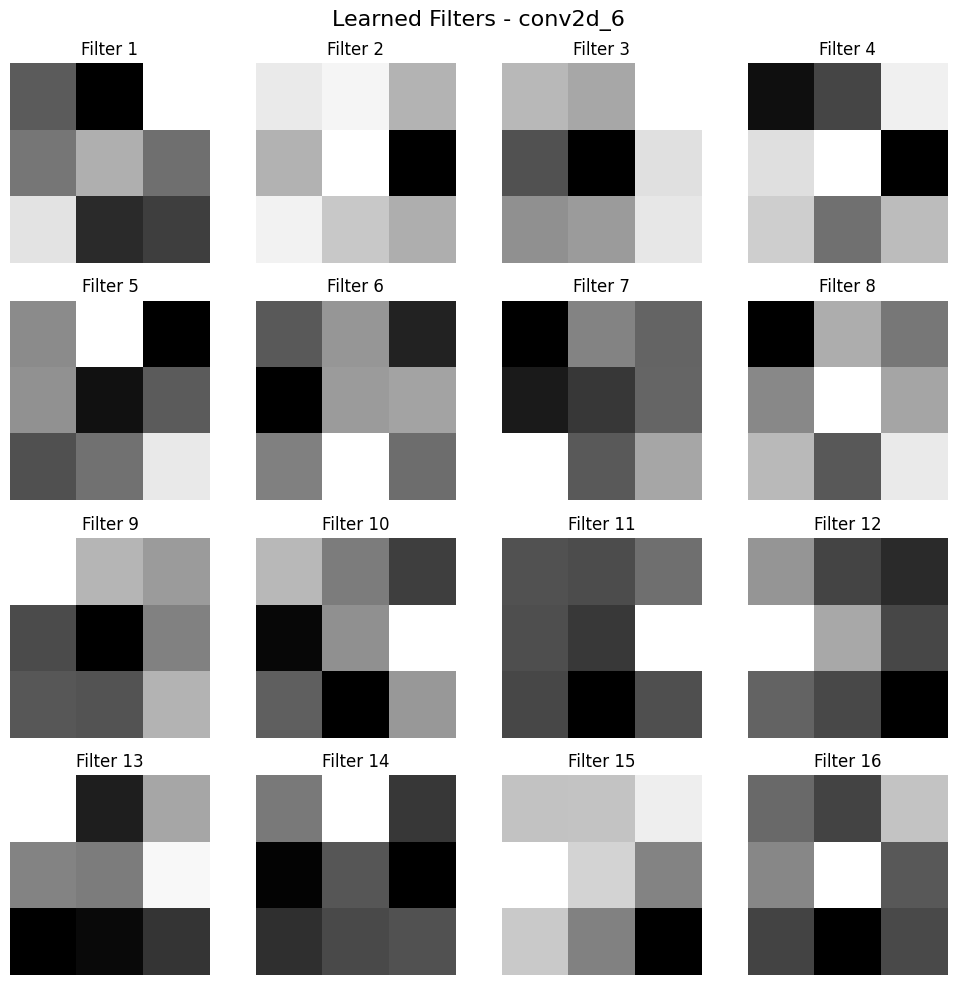

✓ Filters visualized for conv2d_6


In [ ]:
# 6. MAIN EXECUTION

print("\n=== LANGKAH 3: Filter Visualization ===")
print("-" * 40)

# Visualize filters from convolutional layers
for i, conv_layer in enumerate(conv_layers[:6]):
    print(f"\nAnalyzing filters from layer {i+1}: {conv_layer.name}")
    visualize_conv_filters(conv_layer, conv_layer.name)

Penjelasan

- Pengertian Filter dalam CNN

Filter atau kernel adalah elemen inti dalam jaringan convolutional neural network (CNN) yang berfungsi mengekstrak fitur dari data gambar. Filter merupakan matriks bobot kecil yang melakukan operasi konvolusi pada citra input untuk mendeteksi pola-pola tertentu, seperti tepi, garis, atau tekstur. Setiap filter belajar pola berbeda yang membantu model mengenali karakteristik visual penting agar dapat melakukan klasifikasi dengan akurat.


- Visualisasi Filter pada Layer conv2d_1 dan conv2d_2

Pada layer conv2d_1 dan conv2d_2, filter yang divisualisasikan memiliki ukuran 5x5 dan jumlah filter yang sangat banyak (512 pada conv2d_1 dan 256 pada conv2d_2). Filter-filter ini berfungsi untuk menangkap fitur dasar dari gambar, seperti tepi, garis, dan perubahan intensitas warna atau kecerahan. Pola yang terlihat masih sangat sederhana dan abstrak, karena layer awal CNN bertugas mendeteksi ciri-ciri paling fundamental yang menjadi dasar pembentukan fitur lebih kompleks di layer berikutnya.


- Visualisasi Filter pada Layer conv2d_3 dan conv2d_4

Filter pada layer conv2d_3 dan conv2d_4 berukuran lebih kecil, yaitu 3x3, dengan jumlah filter yang lebih sedikit, yakni 128 filter. Pada tahap ini, filter mulai menangkap pola yang lebih rumit dan terfokus, seperti kombinasi bentuk-bentuk dasar yang lebih kompleks dan tekstur pada gambar wajah. Layer ini bertindak sebagai jembatan pengolahan fitur dari yang sangat sederhana ke fitur yang lebih spesifik, sehingga model mulai memahami pola yang lebih bermakna untuk mengklasifikasikan ekspresi wajah.


- Visualisasi Filter pada Layer conv2d_5 dan conv2d_6

Layer-layer terakhir dalam arsitektur, conv2d_5 dan conv2d_6, memiliki filter dengan ukuran 3x3 dan jumlah filter yang cukup besar kembali, yaitu 256 dan 512 filter. Filter pada layer ini menangkap fitur yang sangat kompleks dan abstrak, yang berkaitan langsung dengan karakteristik ekspresi wajah yang akan diklasifikasikan oleh model. Pada tahap ini, filter sudah mempelajari pola spasial yang penting, seperti bentuk alis, mulut, mata, dan ekspresi keseluruhan, sehingga model dapat membedakan dengan akurat antara berbagai ekspresi emosi.

Upload gambar untuk analisis fitur:


Saving S010_004_00000017.png to S010_004_00000017 (1).png

ANALYZING: S010_004_00000017 (1).png
--------------------------------------------------


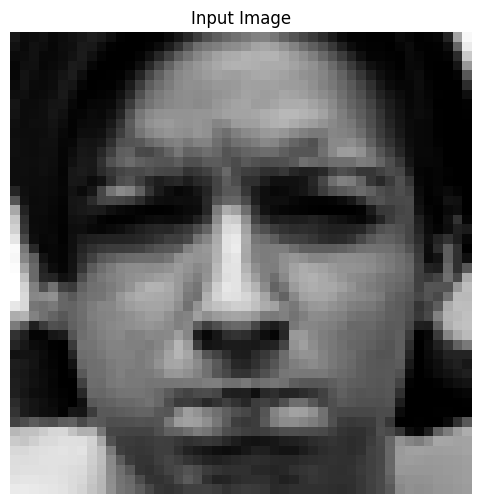

Model Prediction: anger (Confidence: 0.877)

FEATURE MAPS ANALYSIS:
------------------------------
Analyzing Layer 1/6: conv2d_1
Method 1 failed: The layer sequential has never been called and thus has no defined input.


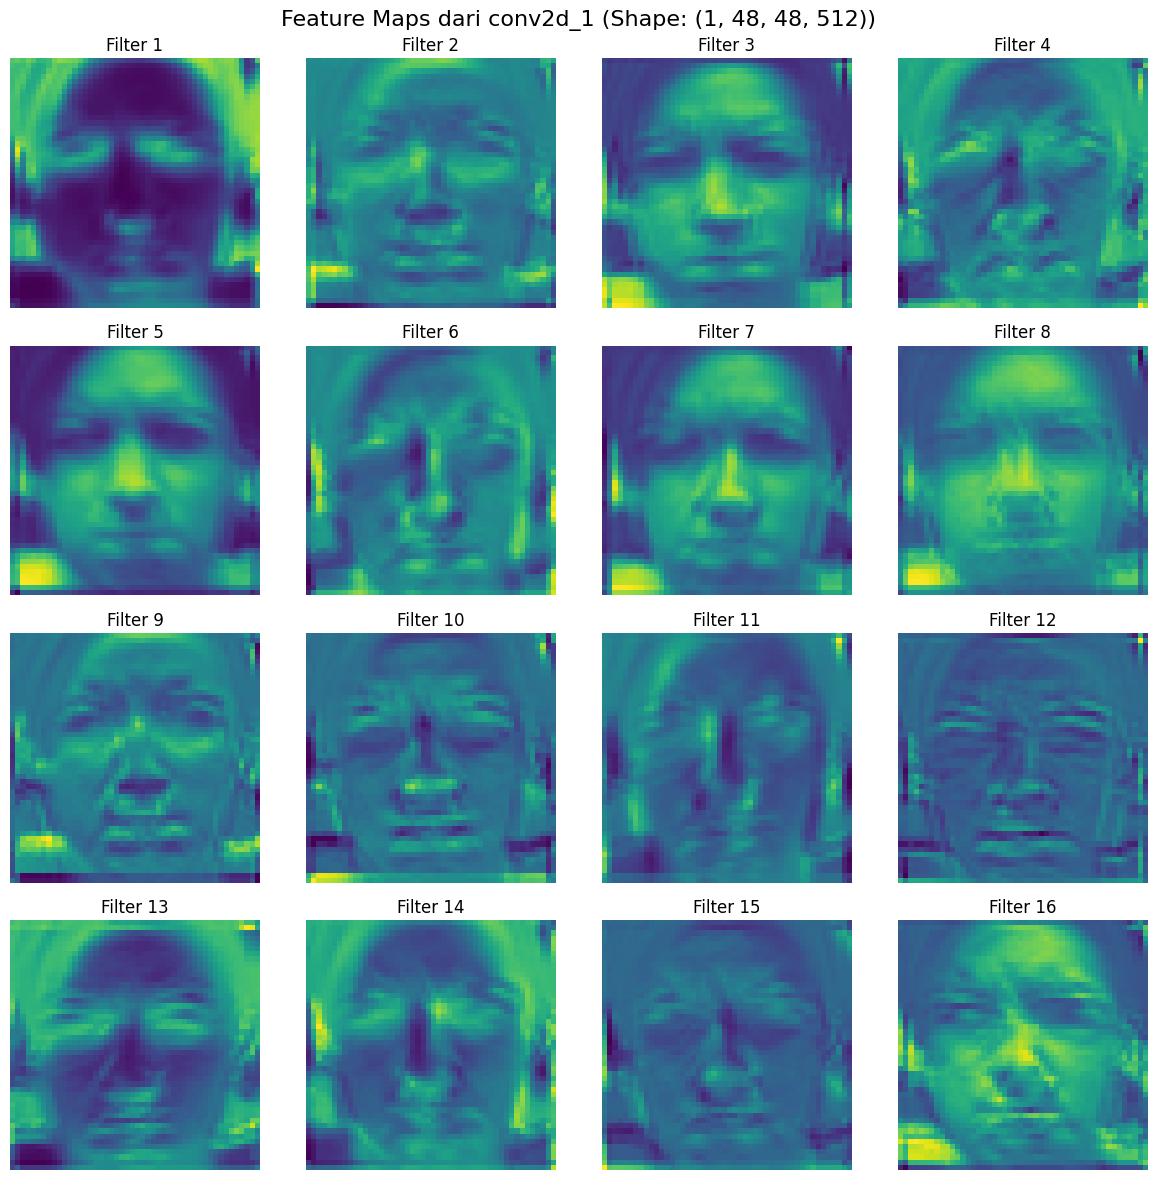

✓ Feature maps visualized for conv2d_1: (1, 48, 48, 512)
Analyzing Layer 2/6: conv2d_2
Method 1 failed: The layer sequential has never been called and thus has no defined input.


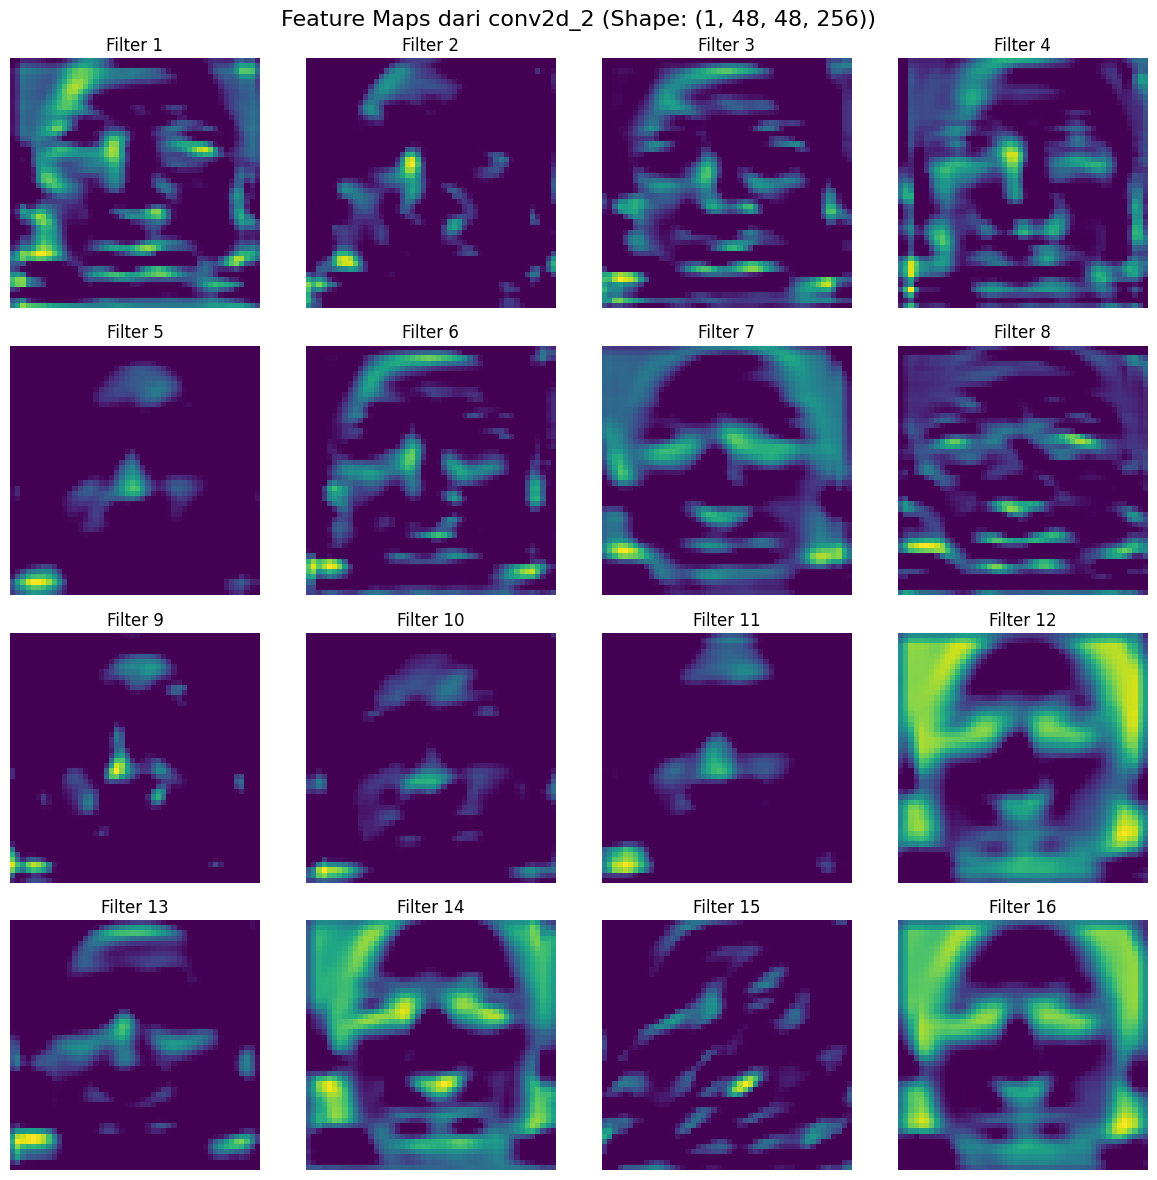

✓ Feature maps visualized for conv2d_2: (1, 48, 48, 256)
Analyzing Layer 3/6: conv2d_3
Method 1 failed: The layer sequential has never been called and thus has no defined input.


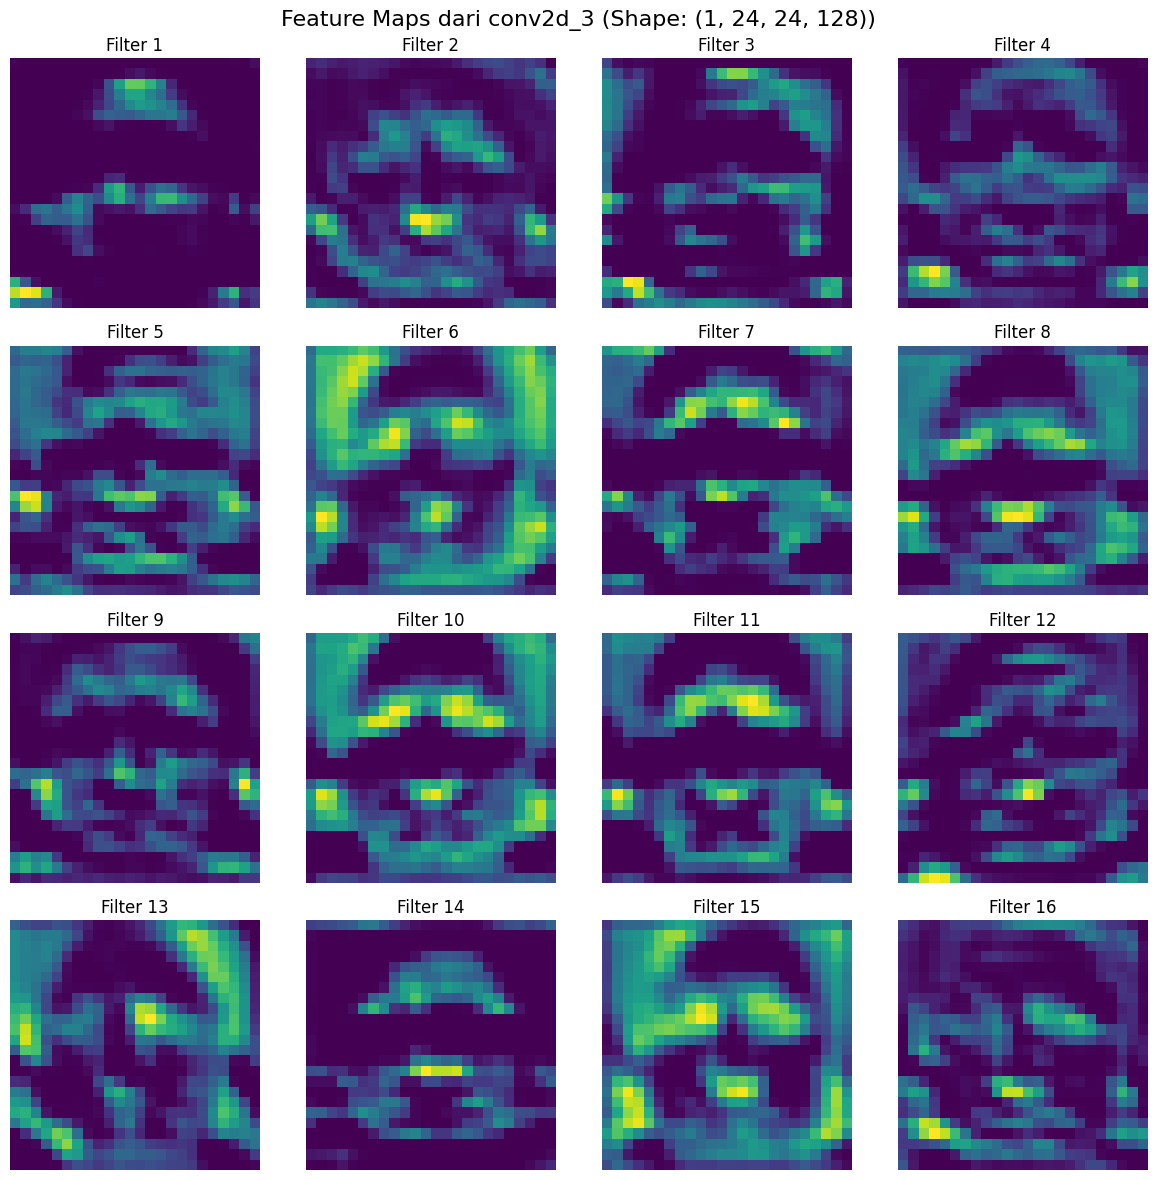

✓ Feature maps visualized for conv2d_3: (1, 24, 24, 128)
Analyzing Layer 4/6: conv2d_4
Method 1 failed: The layer sequential has never been called and thus has no defined input.


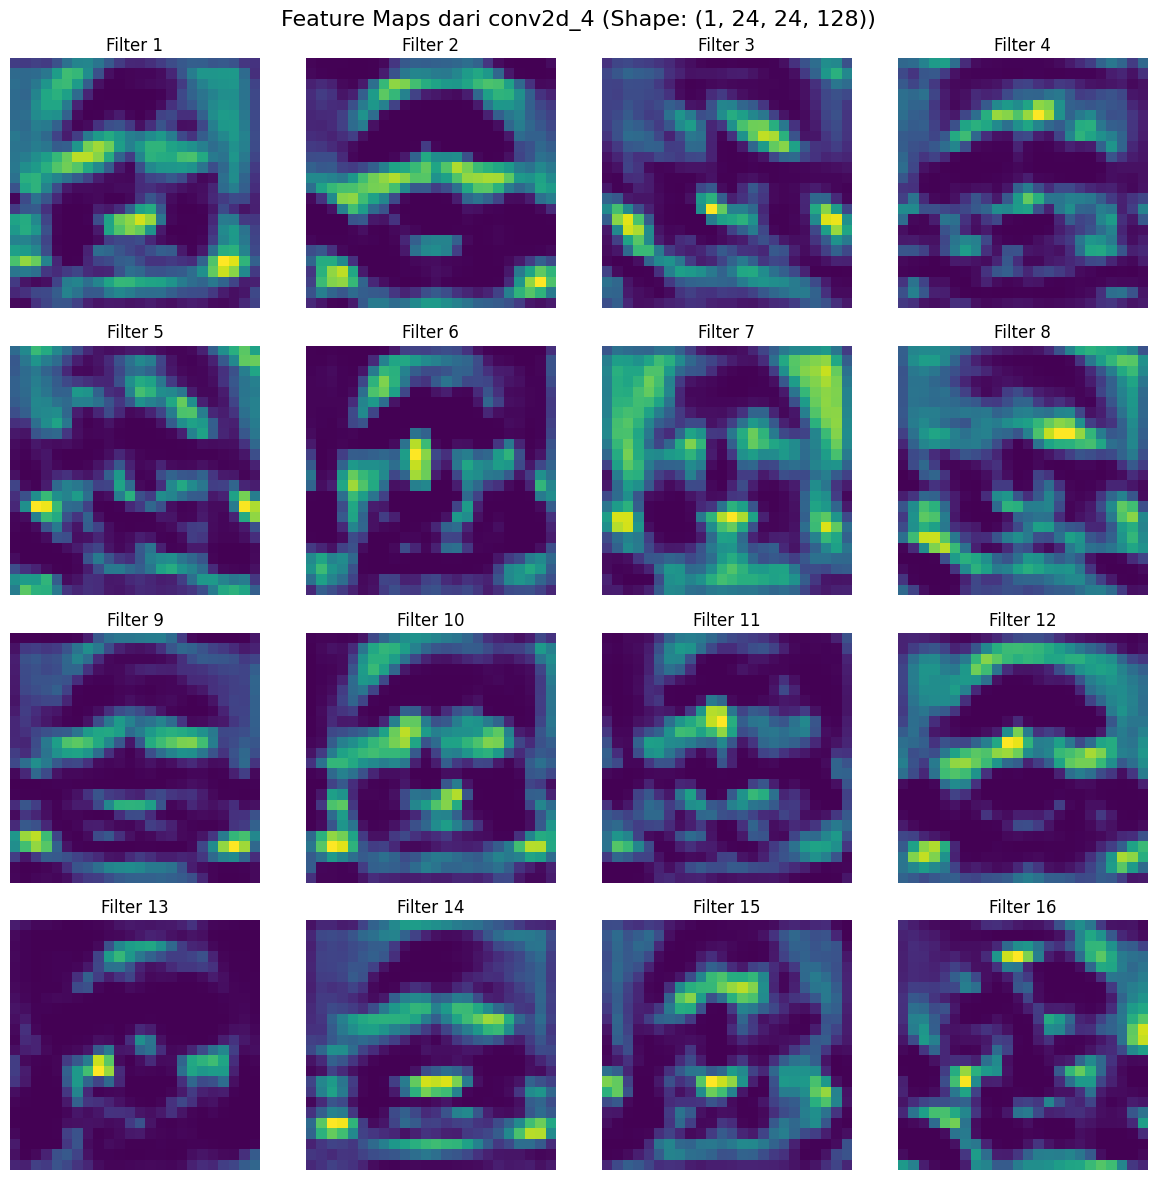

✓ Feature maps visualized for conv2d_4: (1, 24, 24, 128)
Analyzing Layer 5/6: conv2d_5
Method 1 failed: The layer sequential has never been called and thus has no defined input.


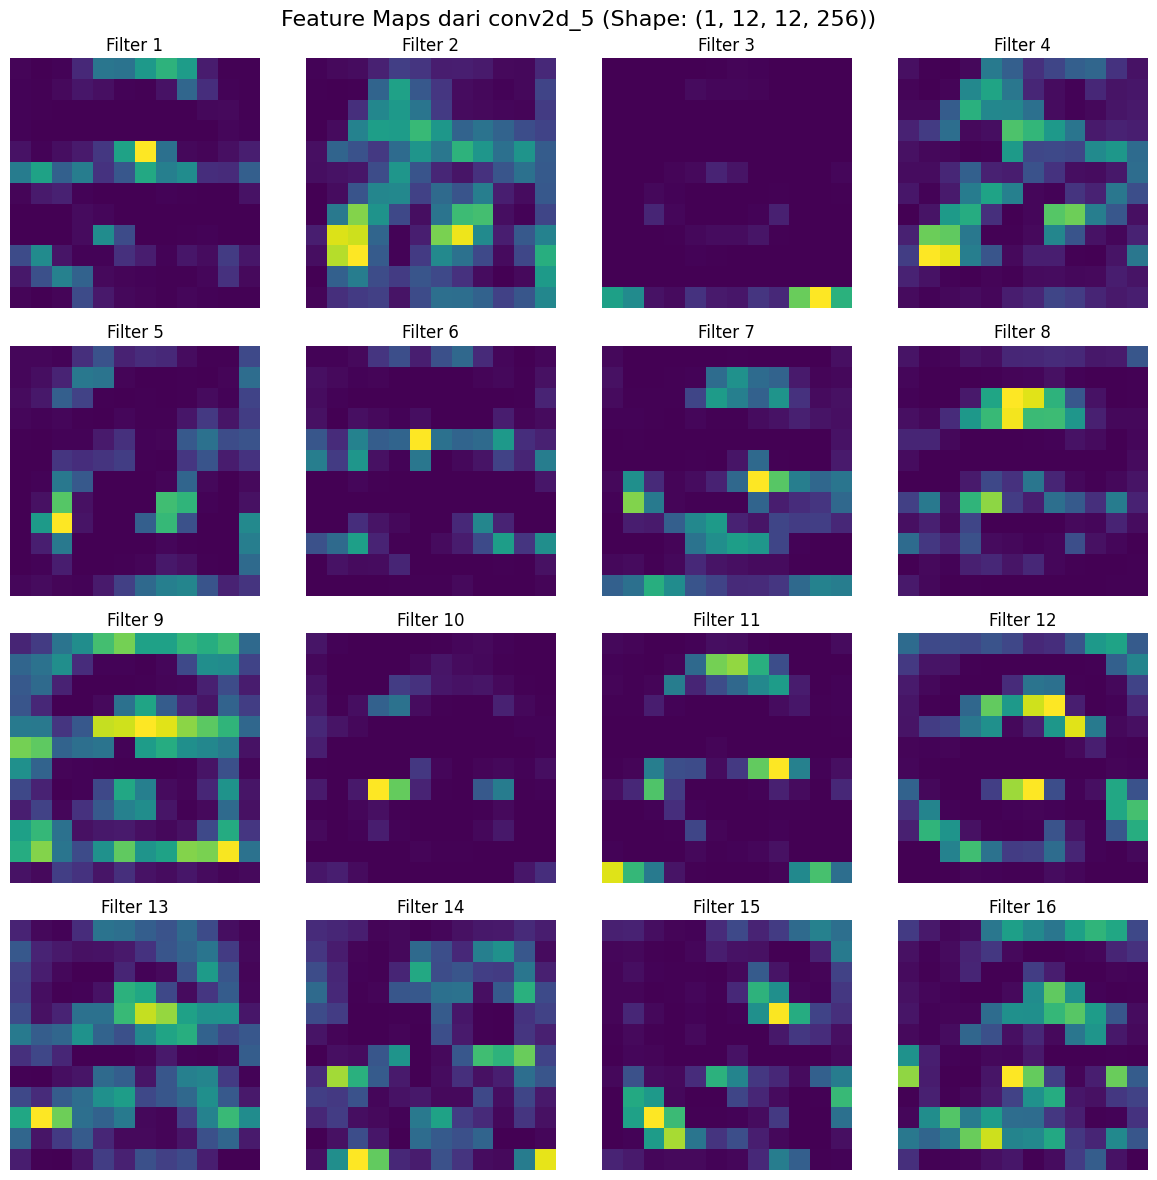

✓ Feature maps visualized for conv2d_5: (1, 12, 12, 256)
Analyzing Layer 6/6: conv2d_6
Method 1 failed: The layer sequential has never been called and thus has no defined input.


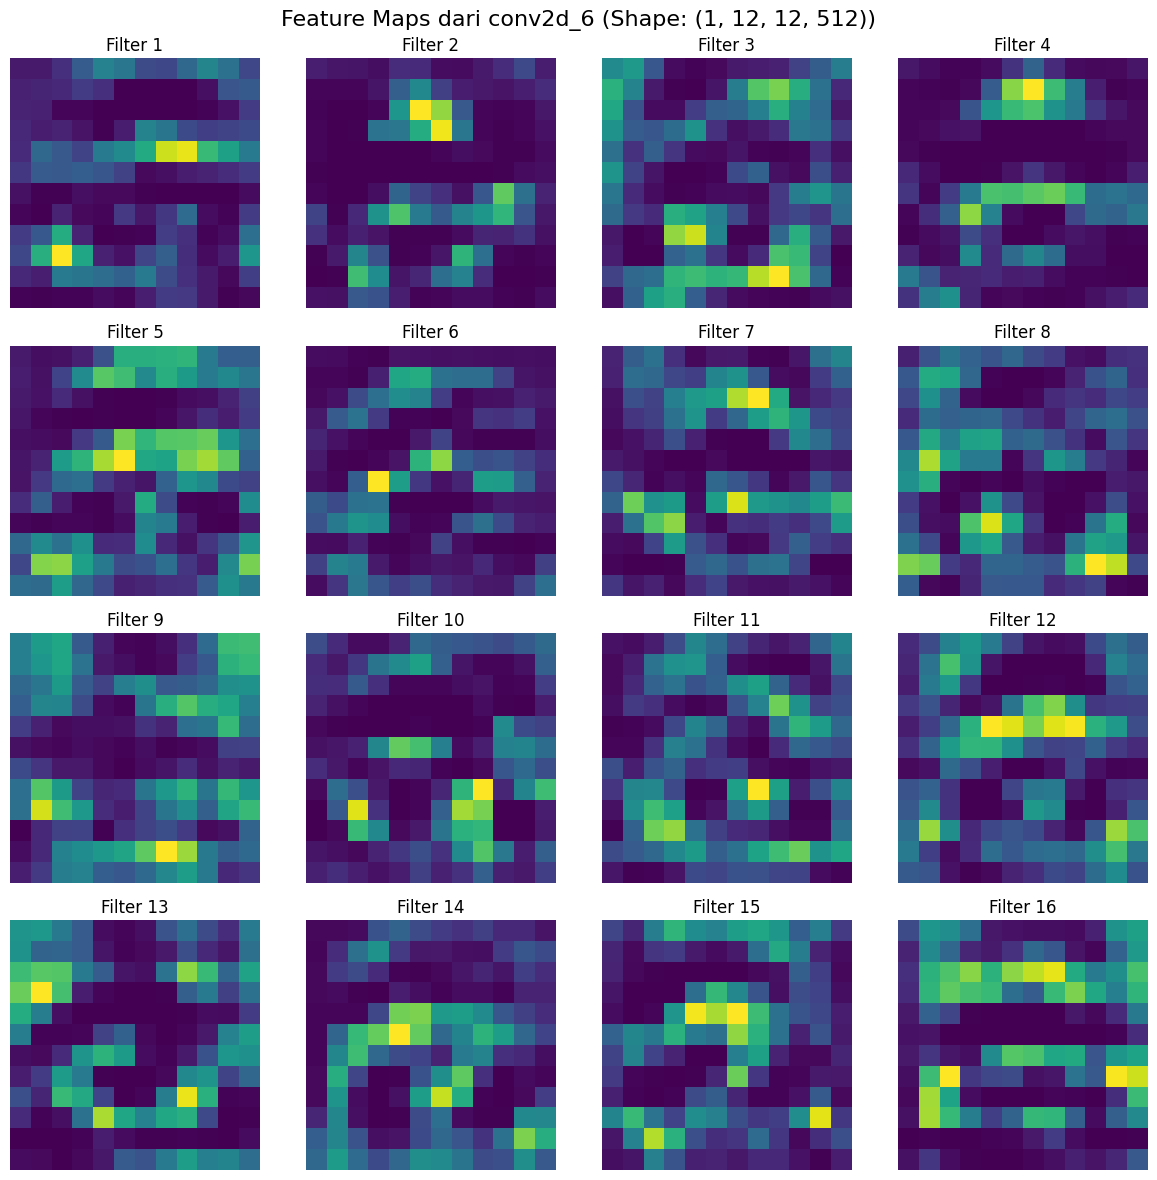

✓ Feature maps visualized for conv2d_6: (1, 12, 12, 512)

GRAD-CAM ANALYSIS:
------------------------------
Prediction: anger (0.877)
Grad-CAM method 1 failed: The layer sequential has never been called and thus has no defined input.
Grad-CAM method 2 failed: The layer sequential has never been called and thus has no defined input.
Grad-CAM could not be generated

ADVANCED FEATURE VISUALIZATION COMPLETE


In [ ]:
# Upload image for feature analysis
print("Upload gambar untuk analisis fitur:")
uploaded_img = files.upload()

if uploaded_img:
    img_path = list(uploaded_img.keys())[0]
    print(f"\nANALYZING: {img_path}")
    print("-" * 50)

    # Load and preprocess image
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Show original image
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    plt.show()

    # Get prediction
    preds = original_model.predict(img_array, verbose=0)
    pred_class = np.argmax(preds[0])
    pred_prob = np.max(preds[0])
    print(f"Model Prediction: {class_names[pred_class]} (Confidence: {pred_prob:.3f})")

    # Feature Maps Analysis
    print(f"\nFEATURE MAPS ANALYSIS:")
    print("-" * 30)

    for i, layer_idx in enumerate(conv_layer_indices):
        print(f"Analyzing Layer {i+1}/{len(conv_layer_indices)}: {all_layers[layer_idx].name}")
        features, layer_name = extract_features_alternative(original_model, layer_idx, img_array)
        visualize_features_alternative(features, layer_name, num_filters=16)

    # # Grad-CAM Analysis
    # print(f"\nGRAD-CAM ANALYSIS:")
    # print("-" * 30)

    # if conv_layer_indices:
    #     last_conv_idx = conv_layer_indices[-1]
    #     heatmap, pred_class, pred_prob = gradcam_alternative(
    #         original_model, img_array, last_conv_idx, class_names
    #     )

    #     if heatmap is not None:
    #         # Resize heatmap and create overlay
    #         heatmap_resized = cv.resize(heatmap, (48, 48))
    #         img_rgb = cv.cvtColor(np.array(img), cv.COLOR_GRAY2RGB)
    #         heatmap_colored = cv.applyColorMap(np.uint8(255 * heatmap_resized), cv.COLORMAP_JET)
    #         superimposed_img = heatmap_colored * 0.6 + img_rgb * 0.4

    #         # Plot results
    #         plt.figure(figsize=(15, 5))

    #         plt.subplot(1, 3, 1)
    #         plt.imshow(img, cmap='gray')
    #         plt.title(f'Original\n{class_names[pred_class]}: {pred_prob:.3f}')
    #         plt.axis('off')

    #         plt.subplot(1, 3, 2)
    #         plt.imshow(heatmap_resized, cmap='jet')
    #         plt.title('Grad-CAM Heatmap')
    #         plt.axis('off')

    #         plt.subplot(1, 3, 3)
    #         plt.imshow(superimposed_img.astype('uint8'))
    #         plt.title('Grad-CAM Overlay')
    #         plt.axis('off')

    #         plt.tight_layout()
    #         plt.show()

    #         print("Grad-CAM analysis completed successfully!")
    #     else:
    #         print("Grad-CAM could not be generated")

else:
    print("No image uploaded")

print("\n" + "="*60)
print("ADVANCED FEATURE VISUALIZATION COMPLETE")
print("="*60)

A. Apa Itu Feature Maps atau Aktivasi Filter?
Saat gambar masuk ke dalam model CNN, tiap layer konvolusi memiliki banyak filter yang “melihat” gambar dan mencoba menangkap pola tertentu, misalnya tepi, bentuk, atau tekstur. Feature maps adalah hasil keluaran dari setiap filter ini, yang menunjukkan bagian gambar mana yang dianggap penting oleh filter tersebut.


B. Visualisasi Feature Maps per Layer
- Pada layer awal (conv2d_1), feature maps menampilkan pola yang masih sederhana, seperti garis, tepi, atau area terang-gelap.
- Pada layer-layer berikutnya (conv2d_2 sampai conv2d_6), feature maps mulai menampilkan pola yang lebih rumit dan spesifik, seperti bagian-bagian wajah (mata, hidung, mulut), ekspresi, atau detail halus lainnya.
- Setiap gambar kecil (feature map) menunjukkan seberapa kuat suatu filter merespon bagian tertentu pada gambar input.


C. Cara Membaca Hasil Visualisasi Feature Maps
1. Setiap gambar kecil mewakili satu filter:
Misalnya “Filter 1” berarti output dari filter pertama di layer tersebut.
2. Warna pada gambar menunjukkan intensitas respon filter:
  - Warna terang (kuning/hijau muda/putih) berarti filter sangat merespon (menganggap fitur penting ada di situ).
  - Warna gelap (biru/ungu/hitam) berarti respon filter lemah atau tidak ada fitur penting di area itu.
3. Perhatikan pola yang muncul:
  - Jika gambar menunjukkan bentuk wajah atau bagian seperti mata dan hidung, berarti filter tersebut menangkap fitur penting yang membantu model mengenali ekspresi.
  - Pola yang abstrak dan tekstur kasar pada layer awal merupakan ciri filter menangkap fitur dasar, sedangkan pola yang lebih jelas dan terfokus muncul pada layer lebih dalam.

